# Librairies

In [6]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# Chargement de données

In [11]:
train_base_dir = '../Data/Data/train/'
clear_dir = os.path.join(train_base_dir, 'clear')
classes = ['clear', 'distorsion1', 'distorsion2', 'distorsion3','mvt1','mvt2','mvt3','gauss1','gauss2','gauss3','pixel1','pixel2','pixel3'] 

def verifier_et_lister_contenu(repertoire):
    if os.path.exists(repertoire):
        print(f"Le dossier '{repertoire}' contient les fichiers suivants :")
        for filename in os.listdir(repertoire):
            print(filename)
    else:
        print(f"Le dossier '{repertoire}' n'existe pas. Vérifiez le chemin.")

verifier_et_lister_contenu(clear_dir)


image_size = (224, 224)
batch_size = 64  


def charger_et_preparer_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)  
    img = tf.image.resize(img, image_size)  
    img = img / 255.0  
    return img


def charger_images_et_labels(repertoire, label):
    images_paths = [os.path.join(repertoire, filename) for filename in os.listdir(repertoire)]
    dataset = tf.data.Dataset.from_tensor_slices(images_paths)
    dataset = dataset.map(lambda img_path: (charger_et_preparer_image(img_path), label), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    return dataset

clear_dataset = charger_images_et_labels(clear_dir, 0)


Le dossier '../Data/Data/train/clear' contient les fichiers suivants :
clear_1.jpg
clear_10.jpg
clear_100.jpg
clear_1000.jpg
clear_1001.jpg
clear_1002.jpg
clear_1003.jpg
clear_1004.jpg
clear_1005.jpg
clear_1006.jpg
clear_1007.jpg
clear_1008.jpg
clear_1009.jpg
clear_101.jpg
clear_1010.jpg
clear_1011.jpg
clear_1012.jpg
clear_1013.jpg
clear_1014.jpg
clear_1015.jpg
clear_1016.jpg
clear_1017.jpg
clear_1018.jpg
clear_1019.jpg
clear_102.jpg
clear_1020.jpg
clear_1021.jpg
clear_1022.jpg
clear_1023.jpg
clear_1024.jpg
clear_1025.jpg
clear_1026.jpg
clear_1027.jpg
clear_1028.jpg
clear_1029.jpg
clear_103.jpg
clear_1030.jpg
clear_1031.jpg
clear_1032.jpg
clear_1033.jpg
clear_1034.jpg
clear_1035.jpg
clear_1036.jpg
clear_1037.jpg
clear_1038.jpg
clear_1039.jpg
clear_104.jpg
clear_1040.jpg
clear_1041.jpg
clear_1042.jpg
clear_1043.jpg
clear_1044.jpg
clear_1045.jpg
clear_1046.jpg
clear_1047.jpg
clear_1048.jpg
clear_1049.jpg
clear_105.jpg
clear_1050.jpg
clear_1051.jpg
clear_1052.jpg
clear_1053.jpg
clear_1054

# Création du modèle

In [14]:


def create_model():
    model = keras.models.Sequential([
        keras.layers.Input((224, 224, 3)),
        keras.layers.Conv2D(32, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(2, activation='softmax')  # 2 classes
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Distorsion

Total d'images dans full_dataset: 3225
41/41 ━━━━━━━━━━━━━━━━━━━━ 33s 782ms/step - accuracy: 0.8403 - loss: 12.0935 - val_accuracy: 1.0000 - val_loss: 0.0017


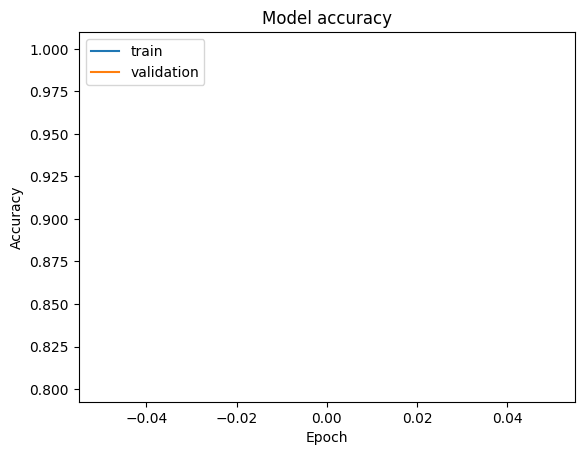

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step
True labels: [1 1 1 1 1 1 1 1 1 1]
Predictions: [1 1 1 1 1 1 1 1 1 1]


c:\Users\Thomas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


ValueError: The number of FixedLocator locations (1), usually from a call to set_ticks, does not match the number of labels (2).

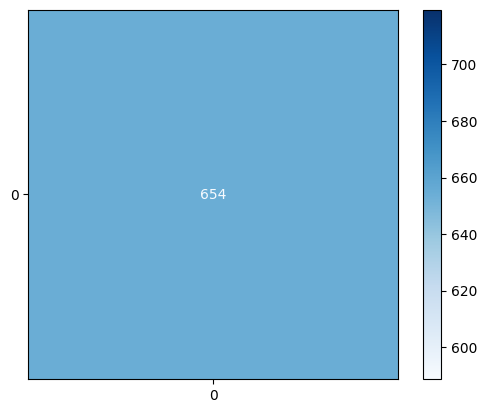

In [18]:
# DIstorsion1
model=create_model()
distorsion1_dir = os.path.join(train_base_dir, 'distorsion1')
distorsion_dataset = charger_images_et_labels(distorsion1_dir, 1)

full_dataset = clear_dataset.concatenate(distorsion_dataset)

total_images = 0
for images, labels in full_dataset:
    total_images += images.shape[0]

print(f"Total d'images dans full_dataset: {total_images}")

train_size = int(0.8 * len(full_dataset))
train_dataset = full_dataset.take(train_size)
validation_dataset = full_dataset.skip(train_size)

history = model.fit(
    train_dataset, 
    validation_data=validation_dataset,  
    epochs=1,   
    verbose=1    
)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

predictions = model.predict(validation_dataset)
predictions = np.argmax(predictions, axis=1)
true_labels = np.concatenate([labels for _, labels in validation_dataset], axis=0)

print(f"True labels: {true_labels[:10]}")
print(f"Predictions: {predictions[:10]}")

cm = confusion_matrix(true_labels, predictions)
class_names = [str(i) for i in range(2)]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.savefig("matrice.png")
plt.show()

# Sauvegarde du modèle
# model.save('my_model.keras') #modele lourd pour push sur git




In [ ]:
# Distorsion2
model=create_model()
distorsion2_dir = os.path.join(train_base_dir, 'distorsion2')
distorsion_dataset = charger_images_et_labels(distorsion2_dir, 1)

full_dataset = clear_dataset.concatenate(distorsion_dataset)

total_images = 0
for images, labels in full_dataset:
    total_images += images.shape[0]

print(f"Total d'images dans clear_dataset: {total_images}")

train_size = int(0.8 * len(full_dataset))
train_dataset = full_dataset.take(train_size)
validation_dataset = full_dataset.skip(train_size)

history = model.fit(
    train_dataset, 
    validation_data=validation_dataset,  
    epochs=10,   
    verbose=1    
)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

predictions = model.predict(validation_dataset)
predictions = np.argmax(predictions, axis=1)
true_labels = np.concatenate([labels for _, labels in validation_dataset], axis=0)

cm = confusion_matrix(true_labels, predictions)
class_names = [str(i) for i in range(2)]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.savefig("matrice.png")
plt.show()

# Sauvegarde du modèle
# model.save('my_model.keras') #modele lourd pour push sur git





In [ ]:
# Distorsion3
model=create_model()
distorsion3_dir = os.path.join(train_base_dir, 'distorsion3')
distorsion_dataset = charger_images_et_labels(distorsion3_dir, 1)

full_dataset = clear_dataset.concatenate(distorsion_dataset)

total_images = 0
for images, labels in full_dataset:
    total_images += images.shape[0]

print(f"Total d'images dans clear_dataset: {total_images}")

train_size = int(0.8 * len(full_dataset))
train_dataset = full_dataset.take(train_size)
validation_dataset = full_dataset.skip(train_size)

history = model.fit(
    train_dataset, 
    validation_data=validation_dataset,  
    epochs=10,   
    verbose=1    
)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

predictions = model.predict(validation_dataset)
predictions = np.argmax(predictions, axis=1)
true_labels = np.concatenate([labels for _, labels in validation_dataset], axis=0)

cm = confusion_matrix(true_labels, predictions)
class_names = [str(i) for i in range(2)]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.savefig("matrice.png")
plt.show()

# Sauvegarde du modèle
# model.save('my_model.keras') #modele lourd pour push sur git





# Flou Mouvement

In [ ]:
# Mvt1
model=create_model()
mvt1_dir = os.path.join(train_base_dir, 'mvt1')
mvt_dataset = charger_images_et_labels(mvt1_dir, 1)

full_dataset = clear_dataset.concatenate(mvt_dataset)

total_images = 0
for images, labels in full_dataset:
    total_images += images.shape[0]

print(f"Total d'images dans clear_dataset: {total_images}")

train_size = int(0.8 * len(full_dataset))
train_dataset = full_dataset.take(train_size)
validation_dataset = full_dataset.skip(train_size)

history = model.fit(
    train_dataset, 
    validation_data=validation_dataset,  
    epochs=10,   
    verbose=1    
)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

predictions = model.predict(validation_dataset)
predictions = np.argmax(predictions, axis=1)
true_labels = np.concatenate([labels for _, labels in validation_dataset], axis=0)

cm = confusion_matrix(true_labels, predictions)
class_names = [str(i) for i in range(2)]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.savefig("matrice.png")
plt.show()

# Sauvegarde du modèle
# model.save('my_model.keras') #modele lourd pour push sur git





In [ ]:
# Mvt2
model=create_model()
mvt2_dir = os.path.join(train_base_dir, 'mvt2')
mvt_dataset = charger_images_et_labels(mvt2_dir, 1)

full_dataset = clear_dataset.concatenate(mvt_dataset)

total_images = 0
for images, labels in full_dataset:
    total_images += images.shape[0]

print(f"Total d'images dans clear_dataset: {total_images}")

train_size = int(0.8 * len(full_dataset))
train_dataset = full_dataset.take(train_size)
validation_dataset = full_dataset.skip(train_size)

history = model.fit(
    train_dataset, 
    validation_data=validation_dataset,  
    epochs=10,   
    verbose=1    
)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

predictions = model.predict(validation_dataset)
predictions = np.argmax(predictions, axis=1)
true_labels = np.concatenate([labels for _, labels in validation_dataset], axis=0)

cm = confusion_matrix(true_labels, predictions)
class_names = [str(i) for i in range(2)]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.savefig("matrice.png")
plt.show()

# Sauvegarde du modèle
# model.save('my_model.keras') #modele lourd pour push sur git





In [ ]:
# Mvt3
model=create_model()
mvt3_dir = os.path.join(train_base_dir, 'mvt3')
mvt_dataset = charger_images_et_labels(mvt3_dir, 1)

full_dataset = clear_dataset.concatenate(mvt_dataset)

total_images = 0
for images, labels in full_dataset:
    total_images += images.shape[0]

print(f"Total d'images dans clear_dataset: {total_images}")

train_size = int(0.8 * len(full_dataset))
train_dataset = full_dataset.take(train_size)
validation_dataset = full_dataset.skip(train_size)

history = model.fit(
    train_dataset, 
    validation_data=validation_dataset,  
    epochs=10,   
    verbose=1    
)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

predictions = model.predict(validation_dataset)
predictions = np.argmax(predictions, axis=1)
true_labels = np.concatenate([labels for _, labels in validation_dataset], axis=0)

cm = confusion_matrix(true_labels, predictions)
class_names = [str(i) for i in range(2)]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.savefig("matrice.png")
plt.show()

# Sauvegarde du modèle
# model.save('my_model.keras') #modele lourd pour push sur git





# Flou gaussien

In [ ]:
# Gauss1
model=create_model()
gauss1_dir = os.path.join(train_base_dir, 'gauss1')
gauss_dataset = charger_images_et_labels(gauss1_dir, 1)

full_dataset = clear_dataset.concatenate(gauss_dataset)

total_images = 0
for images, labels in full_dataset:
    total_images += images.shape[0]

print(f"Total d'images dans clear_dataset: {total_images}")

train_size = int(0.8 * len(full_dataset))
train_dataset = full_dataset.take(train_size)
validation_dataset = full_dataset.skip(train_size)

history = model.fit(
    train_dataset, 
    validation_data=validation_dataset,  
    epochs=10,   
    verbose=1    
)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

predictions = model.predict(validation_dataset)
predictions = np.argmax(predictions, axis=1)
true_labels = np.concatenate([labels for _, labels in validation_dataset], axis=0)

cm = confusion_matrix(true_labels, predictions)
class_names = [str(i) for i in range(2)]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.savefig("matrice.png")
plt.show()

# Sauvegarde du modèle
# model.save('my_model.keras') #modele lourd pour push sur git





In [ ]:
# Gauss2
model=create_model()
gauss2_dir = os.path.join(train_base_dir, 'gauss2')
gauss_dataset = charger_images_et_labels(gauss2_dir, 1)

full_dataset = clear_dataset.concatenate(gauss_dataset)

total_images = 0
for images, labels in full_dataset:
    total_images += images.shape[0]

print(f"Total d'images dans clear_dataset: {total_images}")

train_size = int(0.8 * len(full_dataset))
train_dataset = full_dataset.take(train_size)
validation_dataset = full_dataset.skip(train_size)

history = model.fit(
    train_dataset, 
    validation_data=validation_dataset,  
    epochs=10,   
    verbose=1    
)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

predictions = model.predict(validation_dataset)
predictions = np.argmax(predictions, axis=1)
true_labels = np.concatenate([labels for _, labels in validation_dataset], axis=0)

cm = confusion_matrix(true_labels, predictions)
class_names = [str(i) for i in range(2)]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.savefig("matrice.png")
plt.show()

# Sauvegarde du modèle
# model.save('my_model.keras') #modele lourd pour push sur git





In [ ]:
# Gauss3
model=create_model()
gauss3_dir = os.path.join(train_base_dir, 'gauss3')
gauss_dataset = charger_images_et_labels(gauss3_dir, 1)

full_dataset = clear_dataset.concatenate(gauss_dataset)

total_images = 0
for images, labels in full_dataset:
    total_images += images.shape[0]

print(f"Total d'images dans clear_dataset: {total_images}")

train_size = int(0.8 * len(full_dataset))
train_dataset = full_dataset.take(train_size)
validation_dataset = full_dataset.skip(train_size)

history = model.fit(
    train_dataset, 
    validation_data=validation_dataset,  
    epochs=10,   
    verbose=1    
)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

predictions = model.predict(validation_dataset)
predictions = np.argmax(predictions, axis=1)
true_labels = np.concatenate([labels for _, labels in validation_dataset], axis=0)

cm = confusion_matrix(true_labels, predictions)
class_names = [str(i) for i in range(2)]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.savefig("matrice.png")
plt.show()

# Sauvegarde du modèle
# model.save('my_model.keras') #modele lourd pour push sur git





# Pixelisation

In [ ]:
# Pixel1
model=create_model()
pixel1_dir = os.path.join(train_base_dir, 'pixel1')
pixel_dataset = charger_images_et_labels(pixel1_dir, 1)

full_dataset = clear_dataset.concatenate(pixel_dataset)

total_images = 0
for images, labels in full_dataset:
    total_images += images.shape[0]

print(f"Total d'images dans clear_dataset: {total_images}")

train_size = int(0.8 * len(full_dataset))
train_dataset = full_dataset.take(train_size)
validation_dataset = full_dataset.skip(train_size)

history = model.fit(
    train_dataset, 
    validation_data=validation_dataset,  
    epochs=10,   
    verbose=1    
)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

predictions = model.predict(validation_dataset)
predictions = np.argmax(predictions, axis=1)
true_labels = np.concatenate([labels for _, labels in validation_dataset], axis=0)

cm = confusion_matrix(true_labels, predictions)
class_names = [str(i) for i in range(2)]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.savefig("matrice.png")
plt.show()

# Sauvegarde du modèle
# model.save('my_model.keras') #modele lourd pour push sur git





In [ ]:
# Pixel2
model=create_model()
pixel2_dir = os.path.join(train_base_dir, 'pixel2')
pixel_dataset = charger_images_et_labels(pixel2_dir, 1)

full_dataset = clear_dataset.concatenate(pixel_dataset)

total_images = 0
for images, labels in full_dataset:
    total_images += images.shape[0]

print(f"Total d'images dans clear_dataset: {total_images}")

train_size = int(0.8 * len(full_dataset))
train_dataset = full_dataset.take(train_size)
validation_dataset = full_dataset.skip(train_size)

history = model.fit(
    train_dataset, 
    validation_data=validation_dataset,  
    epochs=10,   
    verbose=1    
)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

predictions = model.predict(validation_dataset)
predictions = np.argmax(predictions, axis=1)
true_labels = np.concatenate([labels for _, labels in validation_dataset], axis=0)

cm = confusion_matrix(true_labels, predictions)
class_names = [str(i) for i in range(2)]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.savefig("matrice.png")
plt.show()

# Sauvegarde du modèle
# model.save('my_model.keras') #modele lourd pour push sur git





In [ ]:
# Pixel3
model=create_model()
pixel3_dir = os.path.join(train_base_dir, 'pixel3')
pixel_dataset = charger_images_et_labels(pixel3_dir, 1)

full_dataset = clear_dataset.concatenate(pixel_dataset)

total_images = 0
for images, labels in full_dataset:
    total_images += images.shape[0]

print(f"Total d'images dans clear_dataset: {total_images}")

train_size = int(0.8 * len(full_dataset))
train_dataset = full_dataset.take(train_size)
validation_dataset = full_dataset.skip(train_size)

history = model.fit(
    train_dataset, 
    validation_data=validation_dataset,  
    epochs=10,   
    verbose=1    
)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

predictions = model.predict(validation_dataset)
predictions = np.argmax(predictions, axis=1)
true_labels = np.concatenate([labels for _, labels in validation_dataset], axis=0)

cm = confusion_matrix(true_labels, predictions)
class_names = [str(i) for i in range(2)]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.savefig("matrice.png")
plt.show()

# Sauvegarde du modèle
# model.save('my_model.keras') #modele lourd pour push sur git



